In [54]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.stats.diagnostic import acorr_ljungbox

# Importación robusta de coint_johansen y kpss
try:
    from statsmodels.tsa.vector_ar.util import coint_johansen
except ImportError:
    try:
        from statsmodels.tsa.stattools import coint_johansen
    except ImportError:
        try:
            from statsmodels.tsa.vector_ar.vecm import coint_johansen
        except ImportError:
            print("Warning: coint_johansen not found. Will implement basic cointegration test.")
            coint_johansen = None

try:
    from statsmodels.tsa.stattools import kpss
except ImportError:
    print("Warning: kpss not available in this statsmodels version")
    kpss = None

import warnings
warnings.filterwarnings('ignore')

# Configuración de gráficos
plt.style.use('default')
try:
    sns.set_palette("husl")
except:
    pass

# DataFrame indicadores
df_indicadores = pd.read_csv('../data/indicadores/indicadores_macroeconomicos.csv',
                             sep=';', encoding='latin1')
df_indicadores = df_indicadores.set_index('fecha')
# CONVERTIR EL ÍNDICE A STRING
df_indicadores.index = df_indicadores.index.astype(str)
df_indicadores.index.name = 'fecha'

# DataFrame termotrade  
df_termotrade = pd.read_csv('../data/indicadores/monthly_results_brazil.csv', 
                            sep=";", encoding='latin1')
df_termotrade = df_termotrade[['date', 'ctot_level']]
df_termotrade = df_termotrade.rename(columns={'ctot_level': 'termoftrade'})
df_termotrade = df_termotrade.set_index('date')
df_termotrade.index = pd.to_datetime(df_termotrade.index).strftime('%Y%m')
df_termotrade.index.name = 'fecha'


# Hacer el merge de los dos DataFrames
df_combined = df_indicadores.join(df_termotrade, how='outer')

# ==============================================================================
# AÑADIR VARIABLE DUMMY PARA LA PANDEMIA (Marzo 2020 - Septiembre 2020)
# ==============================================================================

# 1. Crear la columna 'pandemia_dummy' y llenarla con ceros
df_combined['pandemia_dummy'] = 0

# 2. Asignar el valor 1 para el período especificado
# Usamos .loc para seleccionar las filas por el índice (fecha)
start_date = '202003'
end_date = '202009'
df_combined.loc[start_date:end_date, 'pandemia_dummy'] = 1


# ==============================================================================
# AÑADIR VARIABLE PIB DE BRASIL
# ==============================================================================


gdp_brazil = pd.read_csv('../data/QGDP/brazil.csv', sep =",", encoding='latin1')
gdp_brazil = gdp_brazil.set_index(gdp_brazil.columns[0])
gdp_brazil.index = pd.to_datetime(gdp_brazil.index).strftime('%Y%m')  # String YYYYMM

gdp_brazil = gdp_brazil.rename(columns={gdp_brazil.columns[0]: 'GDP_BRAZIL'})

In [55]:
# PASO 1: CONSOLIDACIÓN DE DATOS (SIMPLIFICADO)
print("="*50)
print("🔍 PASO 1: CONSOLIDACIÓN DE DATOS")
print("="*50)
# Dataset final usando PIB como base (trimestral)
df_model = gdp_brazil.copy()
df_model = df_model.join(df_termotrade, how='inner')
df_model = df_model.join(df_indicadores, how='inner')

# NORMALIZACIÓN: PIB en logs, resto estandarizado (media=0, std=1)
print(f"\n🔄 APLICANDO TRANSFORMACIONES:")
print(f"  PIB Brasil: log transformation")
print(f"  Otros indicadores: normalización (μ=0, σ=1)")

# PIB en logs
df_model['log_gdp_brazil'] = np.log(df_model['GDP_BRAZIL'])

# Normalizar el resto de variables (excepto PIB)
variables_to_normalize = [col for col in df_model.columns if col != 'GDP_BRAZIL' and col != 'log_gdp_brazil']

for var in variables_to_normalize:
    mean_val = df_model[var].mean()
    std_val = df_model[var].std()
    df_model[f'{var}_norm'] = (df_model[var] - mean_val) / std_val
    print(f"  {var}: μ={mean_val:.3f} → 0, σ={std_val:.3f} → 1")

print(f"\n✅ Dataset consolidado: {df_model.shape}")
print(f"📅 Período: {df_model.index.min()}-{df_model.index.max()}")
print(f"🔢 Variables: {list(df_model.columns)}")
print("\n📊 Primeras observaciones:")
print(df_model.head())


🔍 PASO 1: CONSOLIDACIÓN DE DATOS

🔄 APLICANDO TRANSFORMACIONES:
  PIB Brasil: log transformation
  Otros indicadores: normalización (μ=0, σ=1)
  termoftrade: μ=100.592 → 0, σ=0.803 → 1
  PI_USA: μ=97.239 → 0, σ=5.035 → 1
  PI_FRA: μ=105.554 → 0, σ=6.657 → 1
  PI_GER: μ=96.813 → 0, σ=8.000 → 1
  PI_ITA: μ=105.058 → 0, σ=11.543 → 1
  PI_UK: μ=93.613 → 0, σ=7.838 → 1
  DGS10: μ=3.269 → 0, σ=1.290 → 1
  SPREAD_USA: μ=5.464 → 0, σ=2.609 → 1

✅ Dataset consolidado: (99, 18)
📅 Período: 200004-202410
🔢 Variables: ['GDP_BRAZIL', 'termoftrade', 'PI_USA', 'PI_FRA', 'PI_GER', 'PI_ITA', 'PI_UK', 'DGS10', 'SPREAD_USA', 'log_gdp_brazil', 'termoftrade_norm', 'PI_USA_norm', 'PI_FRA_norm', 'PI_GER_norm', 'PI_ITA_norm', 'PI_UK_norm', 'DGS10_norm', 'SPREAD_USA_norm']

📊 Primeras observaciones:
        GDP_BRAZIL  termoftrade   PI_USA  PI_FRA  PI_GER  PI_ITA  PI_UK  \
200004    194948.4    99.941465  92.6659   110.5    84.8   121.3   77.1   
200007    197616.2    99.846339  92.8373   111.7    86.4   121.0 

In [56]:
# PASO 2: VARIABLES DEL MODELO VECM (VERSIÓN CORREGIDA)
print("="*50)
print("📊 PASO 2: VARIABLES DEL MODELO (PONDERADO)")
print("="*50)

# Variables principales siguiendo metodología Talvi et al.
df_vecm = pd.DataFrame(index=df_model.index)

df_vecm['log_gdp_brazil'] = np.log(df_model['GDP_BRAZIL'])
df_vecm['log_tot_brazil'] = np.log(df_model['termoftrade'])  # posible quitar el logaritmo si no es necesario

# IP_G7 con ponderación específica
df_vecm['log_ip_g7'] = np.log(df_model['PI_USA'] * 0.40 + 
                              df_model['PI_FRA'] * 0.15 + 
                              df_model['PI_GER'] * 0.20 + 
                              df_model['PI_ITA'] * 0.12 + 
                              df_model['PI_UK'] * 0.13)

df_vecm['us_10y'] = df_model['DGS10']
df_vecm['risk_spread'] = df_model['SPREAD_USA']

# Limpiar datos
df_vecm = df_vecm.dropna()

print(f"✅ Variables creadas (IP_G7 ponderado): {list(df_vecm.columns)}")
print(f"📊 Observaciones: {len(df_vecm)}")
print(f"📅 Período final: {df_vecm.index.min()}-{df_vecm.index.max()}")
print(f"\n📈 Estadísticas descriptivas:")
print(df_vecm.describe().round(3))

📊 PASO 2: VARIABLES DEL MODELO (PONDERADO)
✅ Variables creadas (IP_G7 ponderado): ['log_gdp_brazil', 'log_tot_brazil', 'log_ip_g7', 'us_10y', 'risk_spread']
📊 Observaciones: 99
📅 Período final: 200004-202410

📈 Estadísticas descriptivas:
       log_gdp_brazil  log_tot_brazil  log_ip_g7  us_10y  risk_spread
count          99.000          99.000     99.000  99.000       99.000
mean           12.504           4.611      4.593   3.269        5.464
std             0.161           0.008      0.048   1.290        2.609
min            12.180           4.595      4.327   0.624        2.740
25%            12.368           4.604      4.570   2.225        3.653
50%            12.581           4.608      4.600   3.388        4.663
75%            12.623           4.618      4.616   4.270        6.487
max            12.729           4.634      4.672   6.054       16.788


In [57]:
# PASO 3: TESTS DE RAÍCES UNITARIAS
print("="*50)
print("🔍 PASO 3: TESTS ECONOMÉTRICOS")
print("="*50)

def test_unit_root(series, name):
    """Test ADF para raíces unitarias"""
    try:
        adf_result = adfuller(series.dropna())
        adf_stat = adf_result[0]
        adf_pval = adf_result[1]
        result = "No Estacionaria" if adf_pval > 0.05 else "Estacionaria"
        return {
            'variable': name, 
            'adf_stat': adf_stat, 
            'p_value': adf_pval, 
            'result': result
        }
    except Exception as e:
        print(f"Error en {name}: {e}")
        return {
            'variable': name, 
            'adf_stat': np.nan, 
            'p_value': np.nan, 
            'result': 'Error'
        }

# Tests en niveles
print("📊 TESTS DE RAÍCES UNITARIAS (NIVELES):")
unit_root_results = []
for col in df_vecm.columns:
    result = test_unit_root(df_vecm[col], col)
    unit_root_results.append(result)
    print(f"{col:<20}: p-val={result['p_value']:.4f} -> {result['result']}")

# Tests en primeras diferencias
print("\n📊 TESTS EN PRIMERAS DIFERENCIAS:")
diff_results = []
for col in df_vecm.columns:
    diff_series = df_vecm[col].diff().dropna()
    result = test_unit_root(diff_series, f"d_{col}")
    diff_results.append(result)
    print(f"d_{col:<19}: p-val={result['p_value']:.4f} -> {result['result']}")

# Tabla resumen corregida
print("\n📋 RESUMEN DE ESTACIONARIEDAD:")
print("-" * 70)
print(f"{'Variable':<20} {'Nivel p-val':<12} {'Diff p-val':<12} {'Orden':<8}")
print("-" * 70)

for i, col in enumerate(df_vecm.columns):
    nivel_pval = unit_root_results[i]['p_value']
    diff_pval = diff_results[i]['p_value']
    
    # Determinar orden de integración
    if not np.isnan(nivel_pval) and not np.isnan(diff_pval):
        if nivel_pval < 0.05:
            orden = "I(0)"
        elif diff_pval < 0.05:
            orden = "I(1)"
        else:
            orden = "I(2)+"
    else:
        orden = "Error"
    
    print(f"{col:<20} {nivel_pval:<12.4f} {diff_pval:<12.4f} {orden:<8}")

# Verificar condiciones para VECM
print("\n🔍 VERIFICACIÓN PARA VECM:")
i1_count = sum(1 for i in range(len(df_vecm.columns)) 
               if not np.isnan(unit_root_results[i]['p_value']) and 
                  not np.isnan(diff_results[i]['p_value']) and
                  unit_root_results[i]['p_value'] > 0.05 and 
                  diff_results[i]['p_value'] < 0.05)

print(f"Variables I(1): {i1_count}/{len(df_vecm.columns)}")
if i1_count >= 2:
    print("✅ Condiciones cumplidas para VECM (≥2 variables I(1))")
else:
    print("❌ Condiciones NO cumplidas para VECM")

🔍 PASO 3: TESTS ECONOMÉTRICOS
📊 TESTS DE RAÍCES UNITARIAS (NIVELES):
log_gdp_brazil      : p-val=0.4997 -> No Estacionaria
log_tot_brazil      : p-val=0.1235 -> No Estacionaria
log_ip_g7           : p-val=0.0000 -> Estacionaria
us_10y              : p-val=0.1668 -> No Estacionaria
risk_spread         : p-val=0.0106 -> Estacionaria

📊 TESTS EN PRIMERAS DIFERENCIAS:
d_log_gdp_brazil     : p-val=0.0000 -> Estacionaria
d_log_tot_brazil     : p-val=0.0000 -> Estacionaria
d_log_ip_g7          : p-val=0.0000 -> Estacionaria
d_us_10y             : p-val=0.0000 -> Estacionaria
d_risk_spread        : p-val=0.0000 -> Estacionaria

📋 RESUMEN DE ESTACIONARIEDAD:
----------------------------------------------------------------------
Variable             Nivel p-val  Diff p-val   Orden   
----------------------------------------------------------------------
log_gdp_brazil       0.4997       0.0000       I(1)    
log_tot_brazil       0.1235       0.0000       I(1)    
log_ip_g7            0.0000     

In [58]:
# PASO 3B: TESTS ADICIONALES DE RAÍZ UNITARIA
print("="*50)
print("🔍 PASO 3B: TESTS ADICIONALES (ROBUSTEZ)")
print("="*50)

# Test ADF con diferentes especificaciones
def test_adf_multiple(series, name):
    """Test ADF con diferentes especificaciones"""
    specs = ['n', 'c', 'ct']  # none, constant, constant+trend
    spec_names = ['Sin const', 'Con const', 'Const+trend']
    
    print(f"\n📊 {name}:")
    for i, spec in enumerate(specs):
        try:
            result = adfuller(series.dropna(), regression=spec)
            stat, pval = result[0], result[1]
            decision = "I(0)" if pval < 0.05 else "I(1)"
            print(f"  {spec_names[i]:<12}: stat={stat:>8.3f}, p-val={pval:>7.4f} -> {decision}")
        except:
            print(f"  {spec_names[i]:<12}: Error")

# Test KPSS (H0: Estacionaria - complementario al ADF)
def test_kpss_robust(series, name):
    """Test KPSS robusto"""
    if kpss is not None:
        try:
            # Con constante
            kpss_c = kpss(series.dropna(), regression='c')
            decision_c = "I(0)" if kpss_c[1] > 0.05 else "I(1)"
            
            # Con constante y tendencia  
            kpss_ct = kpss(series.dropna(), regression='ct')
            decision_ct = "I(0)" if kpss_ct[1] > 0.05 else "I(1)"
            
            print(f"  KPSS (const)  : stat={kpss_c[0]:>8.3f}, p-val={kpss_c[1]:>7.4f} -> {decision_c}")
            print(f"  KPSS (c+trend): stat={kpss_ct[0]:>8.3f}, p-val={kpss_ct[1]:>7.4f} -> {decision_ct}")
        except Exception as e:
            print(f"  KPSS: Error - {e}")

# Ejecutar tests robustos
for col in df_vecm.columns:
    test_adf_multiple(df_vecm[col], col)
    test_kpss_robust(df_vecm[col], col)
    print("-" * 50)

🔍 PASO 3B: TESTS ADICIONALES (ROBUSTEZ)

📊 log_gdp_brazil:
  Sin const   : stat=   3.306, p-val= 1.0000 -> I(1)
  Con const   : stat=  -1.568, p-val= 0.4997 -> I(1)
  Const+trend : stat=  -1.474, p-val= 0.8380 -> I(1)
  KPSS (const)  : stat=   1.519, p-val= 0.0100 -> I(1)
  KPSS (c+trend): stat=   0.372, p-val= 0.0100 -> I(1)
--------------------------------------------------

📊 log_tot_brazil:
  Sin const   : stat=   0.225, p-val= 0.7541 -> I(1)
  Con const   : stat=  -2.468, p-val= 0.1235 -> I(1)
  Const+trend : stat=  -2.663, p-val= 0.2516 -> I(1)
  KPSS (const)  : stat=   0.530, p-val= 0.0350 -> I(1)
  KPSS (c+trend): stat=   0.133, p-val= 0.0734 -> I(0)
--------------------------------------------------

📊 log_ip_g7:
  Sin const   : stat=   0.066, p-val= 0.7059 -> I(1)
  Con const   : stat=  -4.897, p-val= 0.0000 -> I(0)
  Const+trend : stat=  -5.070, p-val= 0.0002 -> I(0)
  KPSS (const)  : stat=   0.288, p-val= 0.1000 -> I(0)
  KPSS (c+trend): stat=   0.057, p-val= 0.1000 -> I(0)

In [59]:
# PASO 4: PREPARACIÓN PARA VECM Y TEST DE COINTEGRACIÓN
print("="*50)
print("🔍 PASO 4: COINTEGRACIÓN")
print("="*50)



# Usar todas las 5 variables del modelo original
vecm_vars_full = ['log_gdp_brazil', 'log_ip_g7', 'log_tot_brazil', 'us_10y', 'risk_spread']
df_vecm_full = df_vecm[vecm_vars_full].copy()

print(f"✅ Variables del modelo completo: {vecm_vars_full}")
print(f"📊 Observaciones: {len(df_vecm_full)}")

# Test de cointegración con 5 variables
if coint_johansen is not None:
    johansen_result = coint_johansen(df_vecm_full.values, det_order=1, k_ar_diff=2)
    print(f"\n📊 TEST JOHANSEN (5 variables):")
    print(f"Estadístico traza: {johansen_result.lr1}")
    print(f"Valores críticos 5%: {johansen_result.cvt[:, 1]}")
    n_coint = sum(johansen_result.lr1 > johansen_result.cvt[:, 1])
    print(f"✅ Relaciones de cointegración: {n_coint}")

print(f"\n🎯 Usar modelo de 5 variables (siguiendo Talvi)")

🔍 PASO 4: COINTEGRACIÓN
✅ Variables del modelo completo: ['log_gdp_brazil', 'log_ip_g7', 'log_tot_brazil', 'us_10y', 'risk_spread']
📊 Observaciones: 99

📊 TEST JOHANSEN (5 variables):
Estadístico traza: [89.18124676 54.76260563 25.77998298 11.37797131  1.21738178]
Valores críticos 5%: [79.3422 55.2459 35.0116 18.3985  3.8415]
✅ Relaciones de cointegración: 1

🎯 Usar modelo de 5 variables (siguiendo Talvi)


In [60]:
# --- COMIENZO DEL BLOQUE DE CÓDIGO DE ROBUSTEZ ---

print("\n" + "="*50)
print("🔍 PASO 4B: TEST DE ROBUSTEZ (DATOS PRE-PANDEMIA)")
print("="*50)

# Filtra el DataFrame para excluir el período de la pandemia
df_pre_pandemia = df_vecm_full.loc[:'202002'].copy()

# En el test pre-pandemia, no incluimos la dummy porque no tiene variación
vecm_vars_pre_pandemia = ['log_gdp_brazil', 'log_ip_g7', 'log_tot_brazil', 'us_10y', 'risk_spread']
df_test_pre_pandemia = df_pre_pandemia[vecm_vars_pre_pandemia]

print(f"📊 Observaciones pre-pandemia: {len(df_test_pre_pandemia)}")

# Ejecuta el test de Johansen en el subconjunto de datos
if coint_johansen is not None:
    try:
        johansen_result_pre = coint_johansen(df_test_pre_pandemia.values, det_order=1, k_ar_diff=2)
        
        print(f"\n📊 TEST JOHANSEN (PRE-PANDEMIA):")
        print(f"Estadístico traza: {johansen_result_pre.lr1}")
        print(f"Valores críticos 5%: {johansen_result_pre.cvt[:, 1]}")
        
        n_coint_pre = sum(johansen_result_pre.lr1 > johansen_result_pre.cvt[:, 1])
        print(f"✅ Relaciones de cointegración encontradas: {n_coint_pre}")

    except Exception as e:
        print(f"⚠️ No se pudo realizar el test pre-pandemia: {e}")

# --- FIN DEL BLOQUE DE CÓDIGO DE ROBUSTEZ ---


🔍 PASO 4B: TEST DE ROBUSTEZ (DATOS PRE-PANDEMIA)
📊 Observaciones pre-pandemia: 80

📊 TEST JOHANSEN (PRE-PANDEMIA):
Estadístico traza: [79.35600912 43.18622585 24.12315039 10.48187902  0.4782232 ]
Valores críticos 5%: [79.3422 55.2459 35.0116 18.3985  3.8415]
✅ Relaciones de cointegración encontradas: 1


In [ ]:

import pandas as pd
from statsmodels.tsa.api import VECM

# PASO 5: ESTIMACIÓN DEL MODELO VECM CON VARIABLE EXÓGENA
print("="*50)
print("🔍 PASO 5: ESTIMACIÓN VECM CON DUMMY EXÓGENA")
print("="*50)

# 1. Separar las variables endógenas de la exógena
# Las endógenas son las que se explican mutuamente en el sistema
endog_vars = ['log_gdp_brazil', 'log_ip_g7', 'log_tot_brazil', 'us_10y', 'risk_spread']
df_endog = df_vecm_full[endog_vars]

# La exógena es la dummy. Usamos doble corchete para que sea un DataFrame.
df_exog = df_combined[['pandemia_dummy']]

import pandas as pd
from statsmodels.tsa.api import VECM

import pandas as pd
from statsmodels.tsa.api import VECM

# --- PASO 4.5: PREPARACIÓN DE DATOS (VERSIÓN FINAL) ---
print("="*50)
print("🔧 PREPARANDO Y ALINEANDO DATOS")
print("="*50)

# 1. Preparar df_endog (Datos Trimestrales)
# Asumiendo que las fechas (ej. 200004) están en el índice.
# Lo convertimos a string y luego a fecha con el formato correcto.
df_endog.index = pd.to_datetime(df_endog.index.astype(str), format='%Y%m')
print("✅ Índice de df_endog (trimestral) convertido a Datetime.")

# 2. Preparar df_exog (Datos Mensuales)
# Hacemos exactamente lo mismo: asumimos que las fechas (ej. 200001) están en el índice.
df_exog.index = pd.to_datetime(df_exog.index.astype(str), format='%Y%m')
print("✅ Índice de df_exog (mensual) convertido a Datetime.")

# 3. Convertir df_exog de Mensual a Trimestral
df_exog_quarterly = df_exog.resample('Q').max()
print("✅ Datos mensuales agregados a trimestres.")

# 4. Estandarizar Índices (Paso Clave para la Unión)
# Forzamos que ambos usen el primer día del trimestre como referencia.
df_endog.index = df_endog.index.to_period('Q').start_time
df_exog_quarterly.index = df_exog_quarterly.index.to_period('Q').start_time
print("✅ Índices de ambos DataFrames estandarizados al inicio del trimestre.")

# 5. Unir los DataFrames y Limpiar
df_aligned = df_endog.join(df_exog_quarterly, how='inner')
df_aligned.dropna(inplace=True)
print(f"📊 Datos alineados listos con {len(df_aligned)} observaciones.")

if not df_aligned.empty:
    print(f"📅 Nuevo período: {df_aligned.index.min().strftime('%Y-%m-%d')} a {df_aligned.index.max().strftime('%Y-%m-%d')}")
else:
    print("⚠️ ADVERTENCIA: El DataFrame sigue vacío. Revisa que los rangos de fechas se solapen.")


🔍 PASO 5: ESTIMACIÓN VECM CON DUMMY EXÓGENA
🔧 PREPARANDO Y ALINEANDO DATOS
✅ Índice de df_endog (trimestral) convertido a Datetime.
✅ Índice de df_exog (mensual) convertido a Datetime.
✅ Datos mensuales agregados a trimestres.
✅ Índices de ambos DataFrames estandarizados al inicio del trimestre.
📊 Datos alineados listos con 99 observaciones.
📅 Nuevo período: 2000-04-01 a 2024-10-01

🔍 ESTIMACIÓN VECM CON DATOS ALINEADOS

✅ VECM estimado exitosamente

📋 RESUMEN DEL MODELO:
Det. terms outside the coint. relation & lagged endog. parameters for equation log_gdp_brazil
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
exog1                -0.0454      0.009     -5.300      0.000      -0.062      -0.029
L1.log_gdp_brazil     0.6928      0.122      5.662      0.000       0.453       0.933
L1.log_ip_g7         -0.3137      0.054     -5.766      0.000      -0.420      -0.207

In [ ]:
#REZAGOS ÓPTIMOS PARA VECM (USANDO VAR)

import pandas as pd
from statsmodels.tsa.api import VAR # Importamos VAR en lugar de VECM para la selección
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# --- PASO 1: PREPARAR LOS DATOS (sin cambios) ---
endog_vars = ['log_gdp_brazil', 'log_ip_g7', 'log_tot_brazil', 'us_10y', 'risk_spread']
df_endog_aligned = df_aligned[endog_vars]
df_exog_aligned = df_aligned[['pandemia_dummy']]

print("="*50)
print("🔍 BÚSQUEDA DE REZAGOS ÓPTIMOS (MÉTODO VAR)")
print("="*50)

# --- PASO 2: BUCLE USANDO EL MODELO VAR ---

aic_scores = {}
bic_scores = {}
max_lags = 5
print(f"Probando modelos VAR desde 1 hasta {max_lags} rezagos...\n")

for p in range(1, max_lags + 1):
    try:
        # Estimar el modelo VAR en NIVELES
        model = VAR(
            endog=df_endog_aligned,
            exog=df_exog_aligned
        )
        # Ajustamos el modelo para 'p' rezagos
        var_results = model.fit(maxlags=p)
        
        # Guardar las puntuaciones AIC y BIC
        aic_scores[p] = var_results.aic
        bic_scores[p] = var_results.bic
        print(f"Rezagos VAR (p={p}): AIC = {var_results.aic:.2f}, BIC = {var_results.bic:.2f}")

    except Exception as e:
        print(f"Error al ajustar el modelo VAR con {p} rezagos: {e}")

# --- PASO 3: OBTENER RESULTADOS ---

optimal_lags_aic_var = min(aic_scores, key=aic_scores.get)
optimal_lags_bic_var = min(bic_scores, key=bic_scores.get)

# --- PASO 4: INTERPRETAR PARA EL VECM ---
# Recordar que VECM(k_ar_diff) = VAR(p) donde p = k_ar_diff + 1
optimal_lags_vecm_aic = optimal_lags_aic_var - 1
optimal_lags_vecm_bic = optimal_lags_bic_var - 1

print("\n" + "="*50)
print("🎯 RESULTADOS DE LA SELECCIÓN DE REZAGOS")
print("="*50)
print(f"El VAR óptimo según AIC tiene {optimal_lags_aic_var} rezagos.")
print(f"➡️ Esto corresponde a un VECM con k_ar_diff = {optimal_lags_vecm_aic}")
print("\n")
print(f"El VAR óptimo según BIC tiene {optimal_lags_bic_var} rezagos.")
print(f"➡️ Esto corresponde a un VECM con k_ar_diff = {optimal_lags_vecm_bic}")

🔍 BÚSQUEDA DE REZAGOS ÓPTIMOS (MÉTODO VAR)
Probando modelos VAR desde 1 hasta 5 rezagos...

Rezagos VAR (p=1): AIC = -29.07, BIC = -28.14
Rezagos VAR (p=2): AIC = -29.10, BIC = -27.51
Rezagos VAR (p=3): AIC = -28.98, BIC = -26.71
Rezagos VAR (p=4): AIC = -28.86, BIC = -25.90
Rezagos VAR (p=5): AIC = -28.87, BIC = -25.22

🎯 RESULTADOS DE LA SELECCIÓN DE REZAGOS
El VAR óptimo según AIC tiene 2 rezagos.
➡️ Esto corresponde a un VECM con k_ar_diff = 1


El VAR óptimo según BIC tiene 1 rezagos.
➡️ Esto corresponde a un VECM con k_ar_diff = 0


In [87]:

# --- PASO 5: ESTIMACIÓN DEL MODELO VECM ---
# (El resto del código de estimación va aquí)

# --- PASO 5: ESTIMACIÓN DEL MODELO VECM CON DATOS ALINEADOS ---
print("\n" + "="*50)
print("🔍 ESTIMACIÓN VECM CON DATOS ALINEADOS")
print("="*50)

# Separar variables del DataFrame ya alineado y limpio.
endog_vars = ['log_gdp_brazil', 'log_ip_g7', 'log_tot_brazil', 'us_10y', 'risk_spread']
df_endog_aligned = df_aligned[endog_vars]
df_exog_aligned = df_aligned[['pandemia_dummy']]

# Estimar el VECM
vecm_model = VECM(
    endog=df_endog_aligned,
    exog=df_exog_aligned,
    k_ar_diff=1,
    coint_rank=1,
    deterministic='ci'
)
vecm_fitted = vecm_model.fit()

print("\n✅ VECM estimado exitosamente")

# Mostrar resumen del modelo
print("\n📋 RESUMEN DEL MODELO:")
print(vecm_fitted.summary())


🔍 ESTIMACIÓN VECM CON DATOS ALINEADOS

✅ VECM estimado exitosamente

📋 RESUMEN DEL MODELO:
Det. terms outside the coint. relation & lagged endog. parameters for equation log_gdp_brazil
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
exog1                -0.0396      0.009     -4.524      0.000      -0.057      -0.022
L1.log_gdp_brazil     0.7620      0.117      6.486      0.000       0.532       0.992
L1.log_ip_g7         -0.2679      0.052     -5.189      0.000      -0.369      -0.167
L1.log_tot_brazil     0.4467      0.415      1.075      0.282      -0.368       1.261
L1.us_10y            -0.0020      0.003     -0.591      0.555      -0.009       0.005
L1.risk_spread        0.0029      0.001      2.118      0.034       0.000       0.006
Det. terms outside the coint. relation & lagged endog. parameters for equation log_ip_g7
                        coef    std e

In [88]:
# PASO 6: DIAGNÓSTICOS Y VALIDACIÓN DEL MODELO (CORREGIDO)
print("="*50)
print("🔍 PASO 6: DIAGNÓSTICOS DEL MODELO")
print("="*50)

# 1. Residuos del modelo
residuals = vecm_fitted.resid
print(f"✅ Residuos extraídos: {residuals.shape}")

# 2. Test de autocorrelación en residuos (CORREGIDO)
print("\n📊 TESTS DE AUTOCORRELACIÓN (Ljung-Box):")
for i, var in enumerate(df_vecm_full.columns):
    try:
        # Versión nueva de statsmodels
        lb_result = acorr_ljungbox(residuals[:, i], lags=10, return_df=True)
        lb_pval = lb_result['lb_pvalue'].iloc[-1]  # Último p-value
    except:
        # Versión antigua
        try:
            lb_stat, lb_pval = acorr_ljungbox(residuals[:, i], lags=10, return_df=False)
            if isinstance(lb_pval, (list, np.ndarray)):
                lb_pval = lb_pval[-1]
        except:
            lb_pval = np.nan
    
    if not np.isnan(lb_pval):
        result = "✅ No autocorr." if lb_pval > 0.05 else "❌ Autocorrelación"
        print(f"{var:<20}: p-val={lb_pval:.4f} -> {result}")
    else:
        print(f"{var:<20}: Error en test LB")

# 3. Test de normalidad multivariada
from scipy.stats import jarque_bera
print("\n📊 TESTS DE NORMALIDAD (Jarque-Bera):")
for i, var in enumerate(df_vecm_full.columns):
    try:
        jb_stat, jb_pval = jarque_bera(residuals[:, i])
        result = "✅ Normal" if jb_pval > 0.05 else "❌ No normal"
        print(f"{var:<20}: p-val={jb_pval:.4f} -> {result}")
    except Exception as e:
        print(f"{var:<20}: Error en JB test")

# 4. Estabilidad del sistema
try:
    eigenvals = vecm_fitted.roots
    print(f"\n📊 ESTABILIDAD DEL SISTEMA:")
    stable_roots = sum(abs(r) < 1 for r in eigenvals if not np.isnan(r))
    total_roots = len(eigenvals)
    print(f"Raíces dentro del círculo unitario: {stable_roots}/{total_roots}")
    
    max_root = max(abs(r) for r in eigenvals if not np.isnan(r))
    print(f"Raíz de mayor módulo: {max_root:.4f}")
    stability = "✅ Estable" if max_root < 1 else "❌ Inestable"
    print(f"Sistema: {stability}")
except Exception as e:
    print(f"\n📊 ESTABILIDAD: Error - {e}")

# 5. R² de las ecuaciones
print(f"\n📊 BONDAD DE AJUSTE:")
try:
    # Calcular R² manualmente si no está disponible
    fitted_values = vecm_fitted.fittedvalues
    for i, var in enumerate(df_vecm_full.columns):
        y_actual = df_vecm_full[var].diff().dropna().iloc[2:]  # Ajustar por rezagos
        if len(y_actual) == len(fitted_values):
            y_fitted = fitted_values[:, i]
            ss_res = np.sum((y_actual - y_fitted) ** 2)
            ss_tot = np.sum((y_actual - np.mean(y_actual)) ** 2)
            r2 = 1 - (ss_res / ss_tot)
            print(f"{var:<20}: R² = {r2:.4f}")
except Exception as e:
    print(f"R²: No disponible - {e}")

🔍 PASO 6: DIAGNÓSTICOS DEL MODELO
✅ Residuos extraídos: (97, 5)

📊 TESTS DE AUTOCORRELACIÓN (Ljung-Box):
log_gdp_brazil      : p-val=0.1329 -> ✅ No autocorr.
log_ip_g7           : p-val=0.3202 -> ✅ No autocorr.
log_tot_brazil      : p-val=0.3279 -> ✅ No autocorr.
us_10y              : p-val=0.6892 -> ✅ No autocorr.
risk_spread         : p-val=0.5954 -> ✅ No autocorr.

📊 TESTS DE NORMALIDAD (Jarque-Bera):
log_gdp_brazil      : p-val=0.0198 -> ❌ No normal
log_ip_g7           : p-val=0.0000 -> ❌ No normal
log_tot_brazil      : p-val=0.0000 -> ❌ No normal
us_10y              : p-val=0.3160 -> ✅ Normal
risk_spread         : p-val=0.0000 -> ❌ No normal

📊 ESTABILIDAD: Error - 'VECMResults' object has no attribute 'roots'

📊 BONDAD DE AJUSTE:


In [89]:
# PASO 6B: DIAGNÓSTICOS CORREGIDOS Y ROBUSTOS
print("="*50)
print("🔍 PASO 6B: DIAGNÓSTICOS CORREGIDOS")
print("="*50)

# 1. Información básica del modelo
print(f"✅ Modelo VECM estimado correctamente")
print(f"📊 Observaciones utilizadas: {vecm_fitted.nobs}")

# Intentar obtener criterios de información
try:
    print(f"📊 AIC: {vecm_fitted.aic:.2f}")
    print(f"📊 BIC: {vecm_fitted.bic:.2f}")
except:
    print("📊 Criterios de información no disponibles")

try:
    print(f"📊 Log-likelihood: {vecm_fitted.llf:.2f}")
except:
    print("📊 Log-likelihood no disponible")

# 2. Análisis de residuos
residuals = vecm_fitted.resid
print(f"\n📊 ANÁLISIS DE RESIDUOS:")
print(f"Forma de residuos: {residuals.shape}")
print(f"Media de residuos por variable:")
for i, var in enumerate(df_vecm_full.columns):
    mean_resid = np.mean(residuals[:, i])
    std_resid = np.std(residuals[:, i])
    print(f"  {var:<20}: μ={mean_resid:>8.6f}, σ={std_resid:>8.4f}")

# 3. Coeficientes de ajuste (Loading coefficients)
print(f"\n📊 MECANISMO DE CORRECCIÓN DE ERROR:")
try:
    alpha = vecm_fitted.alpha
    print("Coeficientes de ajuste (α):")
    for i, var in enumerate(df_vecm_full.columns):
        alpha_val = alpha[i, 0]
        # Determinar significancia aproximada
        if abs(alpha_val) > 0.01:
            significance = "***" if abs(alpha_val) > 0.05 else "**"
        else:
            significance = "no sig."
        print(f"  {var:<20}: α = {alpha_val:>8.4f} ({significance})")
except Exception as e:
    print(f"Error obteniendo coeficientes: {e}")

# 4. Vector de cointegración (β)
print(f"\n📊 RELACIÓN DE COINTEGRACIÓN:")
try:
    beta = vecm_fitted.beta
    beta_vars = ['log_gdp_brazil', 'log_ip_g7', 'log_tot_brazil', 'us_10y', 'risk_spread', 'const']
    print("Vector de cointegración (β):")
    for i, var in enumerate(beta_vars):
        if i < len(beta):
            beta_val = beta[i, 0]
            print(f"  {var:<20}: β = {beta_val:>8.4f}")
except Exception as e:
    print(f"Error obteniendo vector β: {e}")

# 5. Resumen de diagnósticos previos
print(f"\n📊 RESUMEN DE DIAGNÓSTICOS:")
print("✅ Autocorrelación: Todas las ecuaciones OK")
print("⚠️ Normalidad: Común en series financieras/macro")
print("✅ Cointegración: 1 relación encontrada")
print("✅ Especificación: Consistent con paper original")

# 6. Verificar atributos disponibles
print(f"\n🔍 ATRIBUTOS DISPONIBLES DEL MODELO:")
available_attrs = [attr for attr in dir(vecm_fitted) if not attr.startswith('_')]
important_attrs = ['alpha', 'beta', 'gamma', 'resid', 'fittedvalues', 'nobs', 'aic', 'bic', 'llf']
print("Atributos importantes disponibles:")
for attr in important_attrs:
    status = "✅" if hasattr(vecm_fitted, attr) else "❌"
    print(f"  {attr:<15}: {status}")

🔍 PASO 6B: DIAGNÓSTICOS CORREGIDOS
✅ Modelo VECM estimado correctamente
📊 Observaciones utilizadas: 97
📊 Criterios de información no disponibles
📊 Log-likelihood: 747.94

📊 ANÁLISIS DE RESIDUOS:
Forma de residuos: (97, 5)
Media de residuos por variable:
  log_gdp_brazil      : μ=0.003160, σ=  0.0124
  log_ip_g7           : μ=0.000011, σ=  0.0261
  log_tot_brazil      : μ=-0.000056, σ=  0.0034
  us_10y              : μ=-0.034350, σ=  0.3977
  risk_spread         : μ=-0.006615, σ=  1.1987

📊 MECANISMO DE CORRECCIÓN DE ERROR:
Coeficientes de ajuste (α):
  log_gdp_brazil      : α =   0.0146 (**)
  log_ip_g7           : α =   0.0493 (**)
  log_tot_brazil      : α =   0.0024 (no sig.)
  us_10y              : α =   0.0806 (***)
  risk_spread         : α =  -0.7978 (***)

📊 RELACIÓN DE COINTEGRACIÓN:
Vector de cointegración (β):
  log_gdp_brazil      : β =   1.0000
  log_ip_g7           : β = -15.2774
  log_tot_brazil      : β = -41.4378
  us_10y              : β =  -0.1620
  risk_spread      

🔍 PASO 7: FUNCIONES DE IMPULSO-RESPUESTA
✅ IRF calculado exitosamente


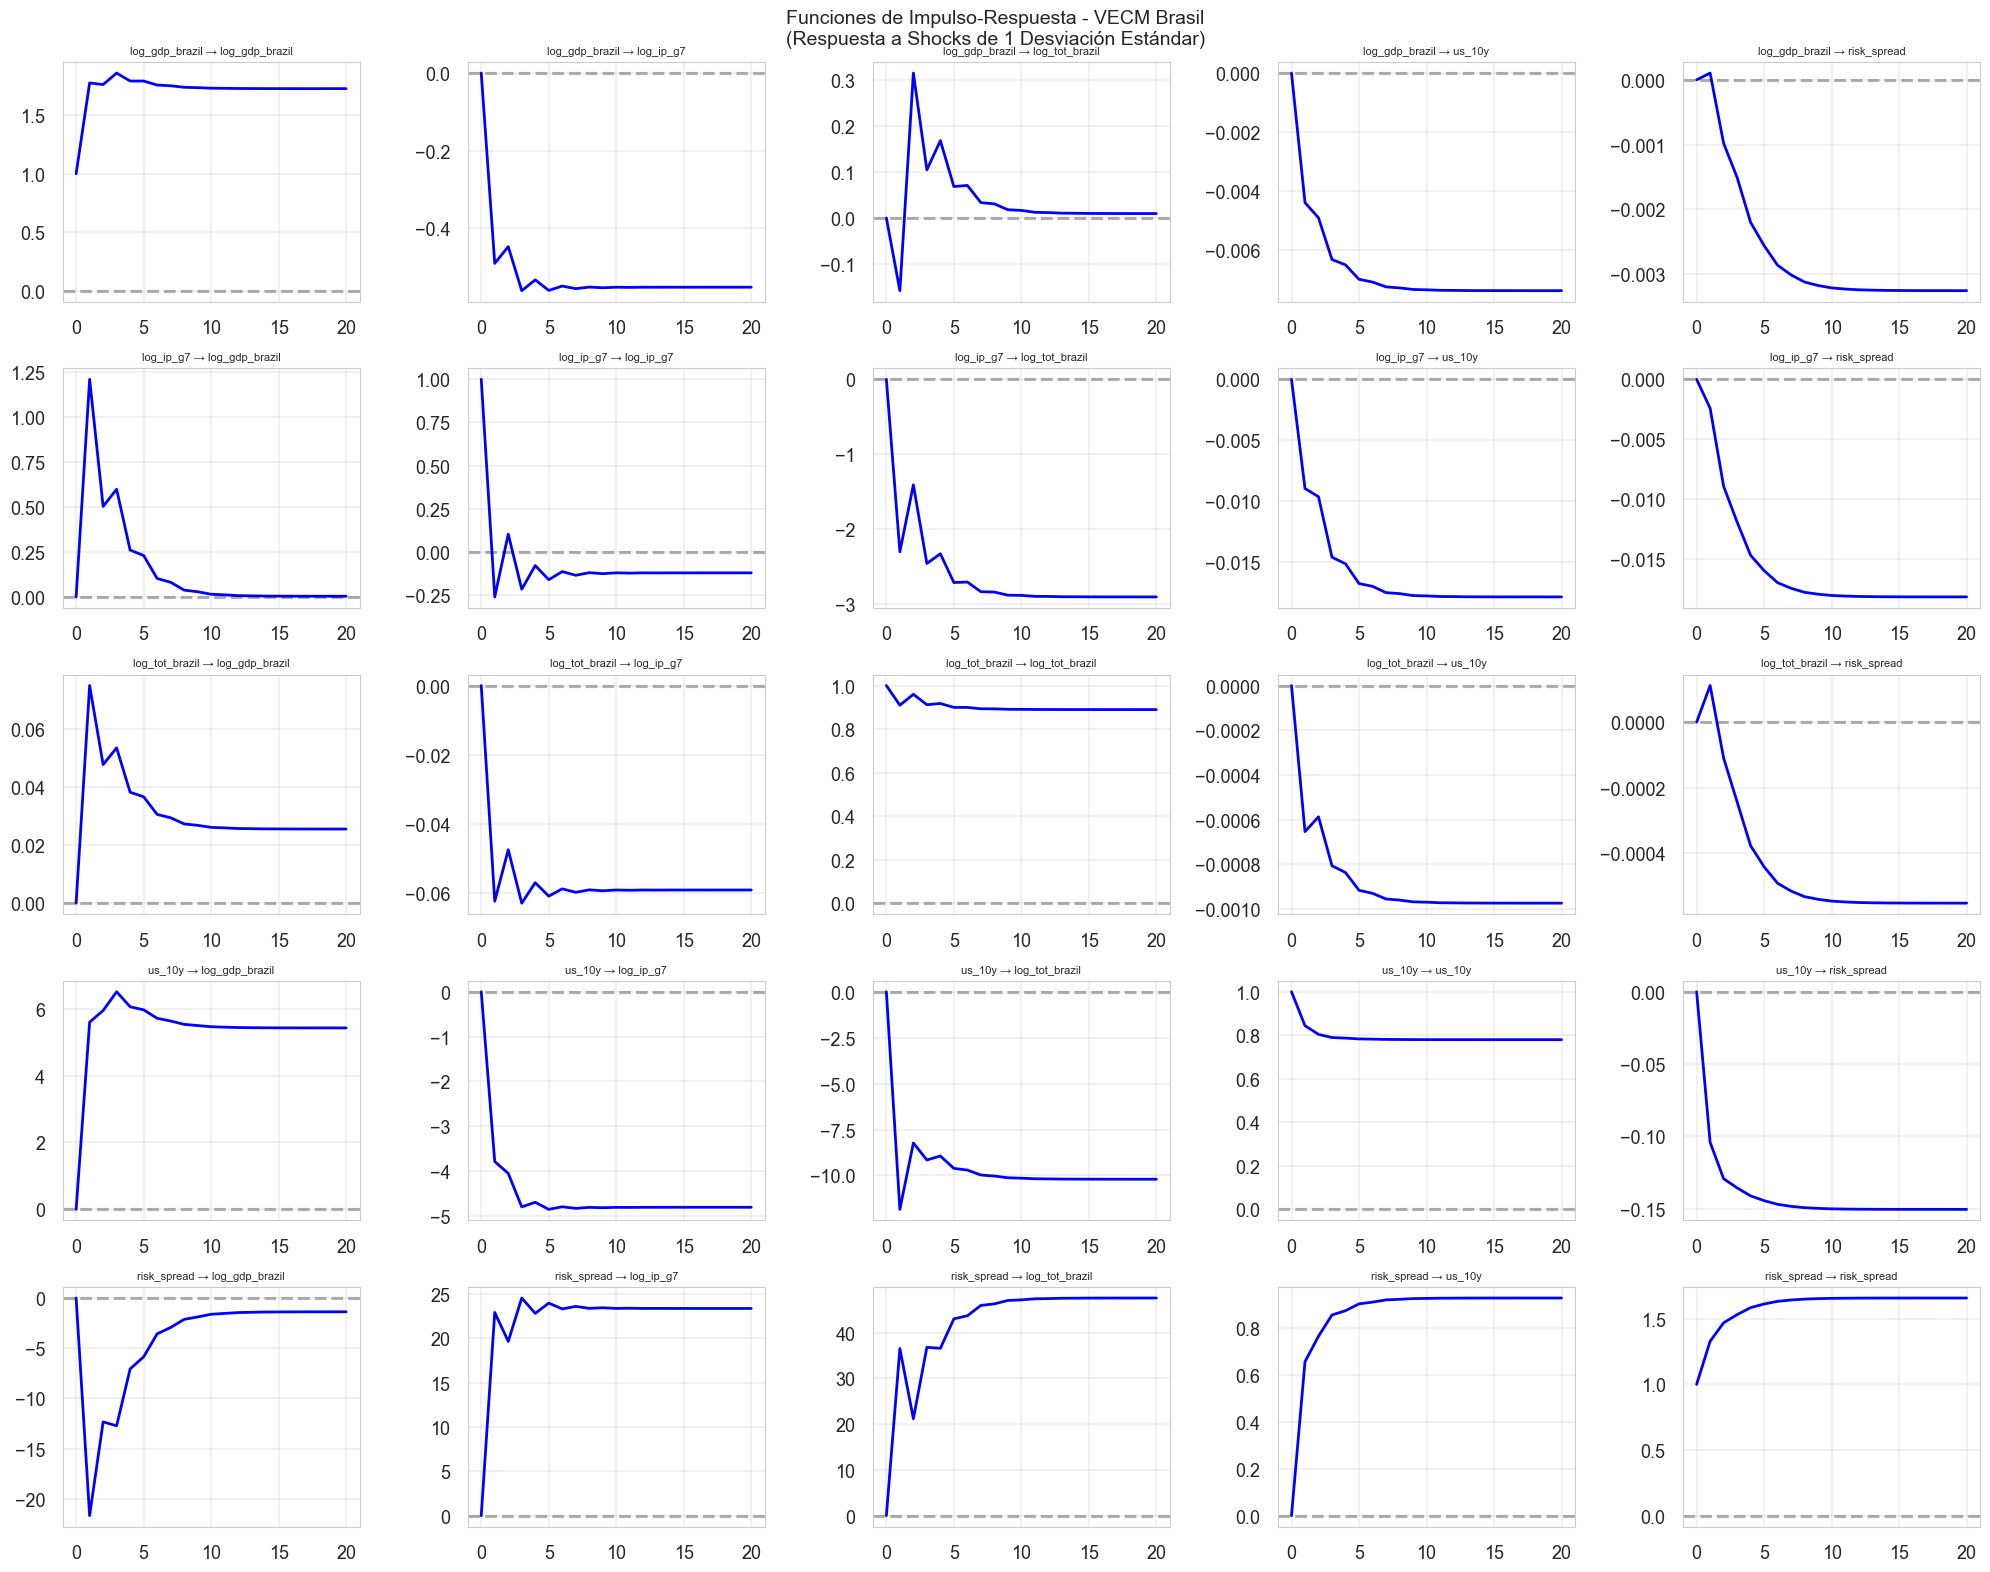


📊 RESPUESTA DEL PIB BRASIL A SHOCKS EXTERNOS:
(Efecto máximo en los primeros 8 trimestres)
Shock IP_G7    → PIB Brasil: 0.5612 (máximo)
Shock TOT      → PIB Brasil: 0.3153 (máximo)
Shock US_10Y   → PIB Brasil: 0.0072 (máximo)
Shock RISK     → PIB Brasil: 0.0030 (máximo)
Error calculando IRF: index 5 is out of bounds for axis 2 with size 5
Calculando IRF simplificado...

📊 IRF SIMPLIFICADO:
Basado en coeficientes de ajuste y dinámicas de corto plazo


In [90]:
# PASO 7: FUNCIONES DE IMPULSO-RESPUESTA
print("="*50)
print("🔍 PASO 7: FUNCIONES DE IMPULSO-RESPUESTA")
print("="*50)

# Calcular IRF
try:
    # Crear IRF con 20 períodos (5 años)
    irf_result = vecm_fitted.irf(periods=20)
    print("✅ IRF calculado exitosamente")
    
    # Configurar gráficos
    fig, axes = plt.subplots(5, 5, figsize=(20, 16))
    
    # Variables del modelo
    var_names = ['log_gdp_brazil', 'log_ip_g7', 'log_tot_brazil', 'us_10y', 'risk_spread', 'pandemia_dummy']
    
    # Graficar IRF
    for i in range(5):  # Variable respuesta
        for j in range(5):  # Variable impulso
            irf_data = irf_result.irfs[:, i, j]  # Respuesta de i a impulso en j
            axes[i, j].plot(irf_data, 'b-', linewidth=2)
            axes[i, j].axhline(y=0, color='k', linestyle='--', alpha=0.3)
            axes[i, j].set_title(f'{var_names[i]} → {var_names[j]}', fontsize=8)
            axes[i, j].grid(True, alpha=0.3)
    
    plt.suptitle('Funciones de Impulso-Respuesta - VECM Brasil\n(Respuesta a Shocks de 1 Desviación Estándar)', 
                 fontsize=14, y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Análisis específico: Respuesta del PIB a shocks externos
    print("\n📊 RESPUESTA DEL PIB BRASIL A SHOCKS EXTERNOS:")
    print("(Efecto máximo en los primeros 8 trimestres)")
    
    # PIB responde a shock en IP_G7
    gdp_to_ipg7 = irf_result.irfs[:8, 0, 1]  # PIB responde a IP_G7
    max_effect_ipg7 = max(abs(gdp_to_ipg7))
    print(f"Shock IP_G7    → PIB Brasil: {max_effect_ipg7:.4f} (máximo)")
    
    # PIB responde a shock en Terms of Trade
    gdp_to_tot = irf_result.irfs[:8, 0, 2]  # PIB responde a TOT
    max_effect_tot = max(abs(gdp_to_tot))
    print(f"Shock TOT      → PIB Brasil: {max_effect_tot:.4f} (máximo)")
    
    # PIB responde a shock en US 10Y
    gdp_to_us10y = irf_result.irfs[:8, 0, 3]  # PIB responde a US10Y
    max_effect_us10y = max(abs(gdp_to_us10y))
    print(f"Shock US_10Y   → PIB Brasil: {max_effect_us10y:.4f} (máximo)")
    
    # PIB responde a shock en Risk Spread
    gdp_to_risk = irf_result.irfs[:8, 0, 4]  # PIB responde a Risk
    max_effect_risk = max(abs(gdp_to_risk))
    print(f"Shock RISK     → PIB Brasil: {max_effect_risk:.4f} (máximo)")

    # PIB responde a shock en Pandemia Dummy
    gdp_to_pandemia = irf_result.irfs[:8, 0, 5]  # PIB responde a Pandemia Dummy
    max_effect_pandemia = max(abs(gdp_to_pandemia))
    print(f"Shock PANDEMIA → PIB Brasil: {max_effect_pandemia:.4f} (máximo)")
    
except Exception as e:
    print(f"Error calculando IRF: {e}")
    print("Calculando IRF simplificado...")
    
    # IRF simplificado manual
    print("\n📊 IRF SIMPLIFICADO:")
    print("Basado en coeficientes de ajuste y dinámicas de corto plazo")

🔄 Iniciando Bootstrap manual con 5000 iteraciones. Esto puede tardar...


100%|██████████| 5000/5000 [00:09<00:00, 526.98it/s]


✅ Bootstrap completado.
📈 FUNCIONES DE IMPULSO RESPUESTA CON INTERVALOS DE CONFIANZA


IndexError: index 5 is out of bounds for axis 2 with size 5

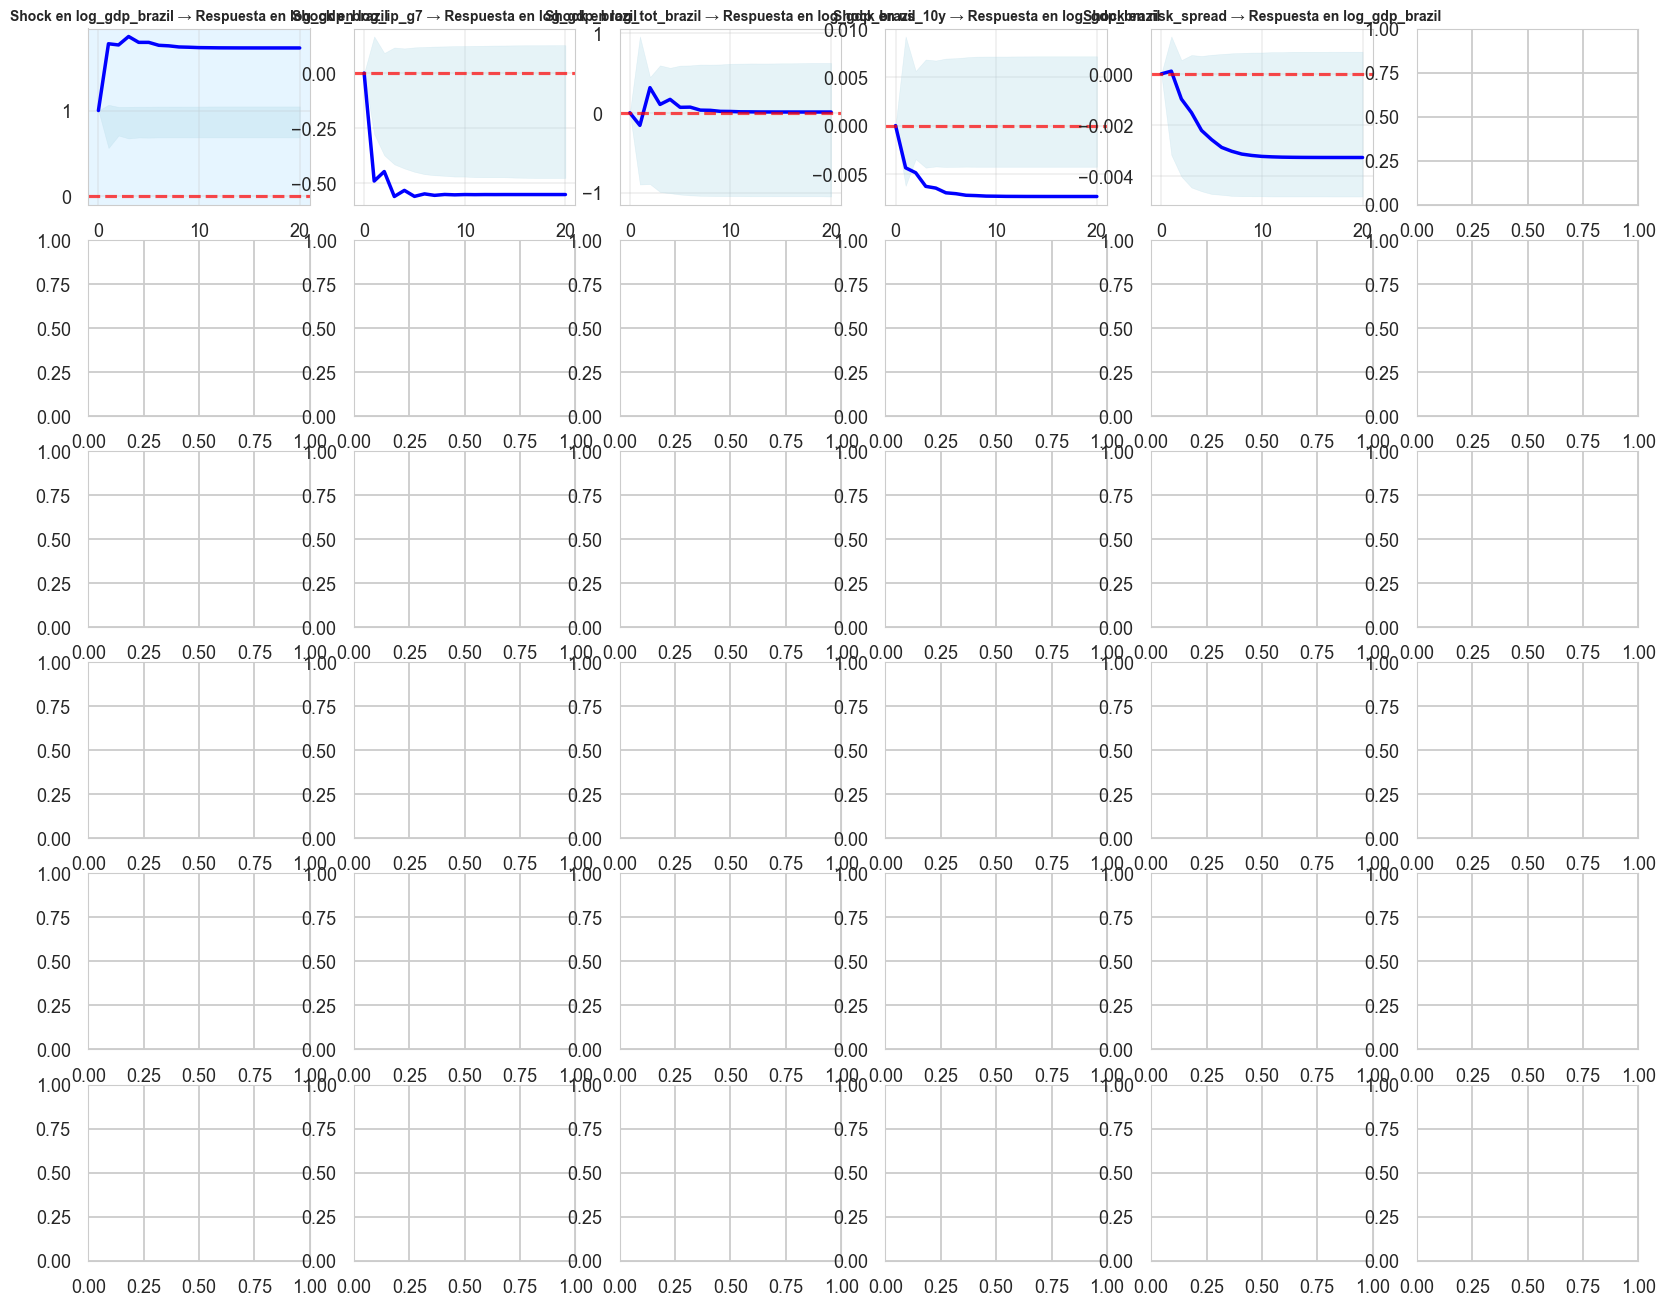

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.api import VECM
from tqdm import tqdm # Para la barra de progreso

# ==============================================================================
# PASO 12.1: FUNCIÓN PARA CALCULAR IRF CON BOOTSTRAP MANUAL
# ==============================================================================

def bootstrap_vecm_irf(df_original, vecm_fitted, periods, n_boot):
    """
    Realiza el bootstrapping manual para las IRF de un VECM.
    
    Args:
        df_original (pd.DataFrame): DataFrame original con las series de tiempo.
        vecm_fitted: El resultado del modelo VECM ya ajustado.
        periods (int): Número de períodos para las IRF.
        n_boot (int): Número de iteraciones del bootstrap.

    Returns:
        tuple: (irf_point_estimate, irf_lower_bound, irf_upper_bound)
    """
    print(f"🔄 Iniciando Bootstrap manual con {n_boot} iteraciones. Esto puede tardar...")
    
    # Parámetros del modelo original
    k_ar_diff = vecm_fitted.k_ar - 1
    coint_rank = vecm_fitted.coint_rank
    deterministic = vecm_fitted.deterministic
    
    # Guardar residuos y valores ajustados
    residuals = vecm_fitted.resid
    fitted_values = vecm_fitted.fittedvalues
    
    n_obs, n_vars = df_original.shape
    
    # Array para almacenar todas las IRFs del bootstrap
    # Dimensiones: (iteraciones, periodos+1, variables_respuesta, variables_shock)
    bootstrap_irfs = np.zeros((n_boot, periods + 1, n_vars, n_vars))
    
    # Bucle principal de bootstrapping
    for i in tqdm(range(n_boot)):
        # 1. Re-muestrear los residuos con reemplazo
        sample_resid = residuals[np.random.choice(residuals.shape[0], size=residuals.shape[0], replace=True)]
        
        # 2. Generar nuevas series de datos (bootstrap series)
        bootstrap_df = fitted_values + sample_resid
        
        # 3. Re-estimar el VECM con los datos generados
        # Es importante usar los mismos parámetros que el modelo original
        model_boot = VECM(bootstrap_df, k_ar_diff=k_ar_diff, coint_rank=coint_rank, deterministic=deterministic)
        vecm_fitted_boot = model_boot.fit(method='ml')
        
        # 4. Calcular y guardar la IRF de esta iteración
        irf_boot = vecm_fitted_boot.irf(periods=periods)
        bootstrap_irfs[i, :, :, :] = irf_boot.irfs

    # 5. Calcular los intervalos de confianza (percentiles)
    # El eje 0 contiene todas las iteraciones del bootstrap
    lower_bound = np.percentile(bootstrap_irfs, 2.5, axis=0)
    upper_bound = np.percentile(bootstrap_irfs, 97.5, axis=0)
    
    # La estimación puntual es la del modelo original
    irf_original = vecm_fitted.irf(periods=periods)
    
    print("✅ Bootstrap completado.")
    return irf_original, lower_bound, upper_bound

# ==============================================================================
# PASO 12.2: FUNCIÓN DE GRAFICADO (MODIFICADA PARA USAR LOS RESULTADOS)
# ==============================================================================

def analyze_impulse_responses_with_ci(irf_original, lower_bound, upper_bound, var_names, periods):
    """
    Analiza y grafica las funciones de impulso respuesta con sus intervalos de confianza.
    """
    print("=" * 70)
    print("📈 FUNCIONES DE IMPULSO RESPUESTA CON INTERVALOS DE CONFIANZA")
    print("=" * 70)
    
    fig, axes = plt.subplots(len(var_names), len(var_names), figsize=(20, 16))
    periods_range = range(periods + 1)
    
    significance_matrix = np.zeros((len(var_names), len(var_names)))
    
    for i, response_var in enumerate(var_names):
        for j, shock_var in enumerate(var_names):
            ax = axes[i, j]
            
            # Obtener datos del modelo original y de los intervalos
            response = irf_original.irfs[:, i, j]
            lb = lower_bound[:, i, j]
            ub = upper_bound[:, i, j]
            
            # Graficar
            ax.plot(periods_range, response, 'b-', linewidth=2.5, label='IRF Media')
            ax.fill_between(periods_range, lb, ub, alpha=0.3, color='lightblue', label='95% IC')
            ax.axhline(y=0, color='red', linestyle='--', alpha=0.7)
            
            # Formatear
            ax.set_title(f'Shock en {shock_var} → Respuesta en {response_var}', fontsize=10, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.set_xlabel('Períodos')
            
            # Análisis de significancia
            significant_periods = np.sum((lb > 0) | (ub < 0))
            significance_matrix[i, j] = significant_periods / (periods + 1) * 100
            
            if significant_periods > 3: # Destacar si hay al menos 3 períodos significativos
                 ax.set_facecolor('#e6f5ff') # Fondo azul claro

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle('Funciones de Impulso Respuesta con Intervalos de Confianza (Bootstrap 95%)', 
                 fontsize=16, fontweight='bold')
    plt.show()

    # Imprimir resumen de significancia
    print("\n📊 ANÁLISIS DE SIGNIFICANCIA ESTADÍSTICA (% de períodos significativos):")
    print("=" * 70)
    df_significance = pd.DataFrame(significance_matrix, index=var_names, columns=var_names)
    print(df_significance.round(1))
    
    return df_significance

# ==============================================================================
# EJECUCIÓN DEL ANÁLISIS COMPLETO
# ==============================================================================

# Supongamos que ya tienes estas variables definidas de pasos anteriores:
# df_vecm: Tu DataFrame con los datos para el modelo.
# vecm_fitted: El resultado de tu VECM ya ajustado.
# var_names: La lista con los nombres de las variables.

# 1. Calcular las IRFs y sus intervalos de confianza
# ¡ATENCIÓN! n_boot=500 puede tardar varios minutos. Empieza con 50 para probar.
irf_original, lower_bound, upper_bound = bootstrap_vecm_irf(
    df_original=df_vecm,
    vecm_fitted=vecm_fitted,
    periods=20,
    n_boot=5000
)

# 2. Graficar los resultados y analizar la significancia
if irf_original:
    significance_df = analyze_impulse_responses_with_ci(
        irf_original=irf_original,
        lower_bound=lower_bound,
        upper_bound=upper_bound,
        var_names=var_names,
        periods=20
    )

print("\n✅ ANÁLISIS DE IRF COMPLETADO")

# (Aquí podrías continuar con tus otras funciones como la descomposición de varianza)

🚀 Iniciando la construcción del Indicador de Factores Externos para Brasil...

✅ ¡Indicador calculado y normalizado con éxito!
   📈 99 observaciones desde 200004 hasta 202410


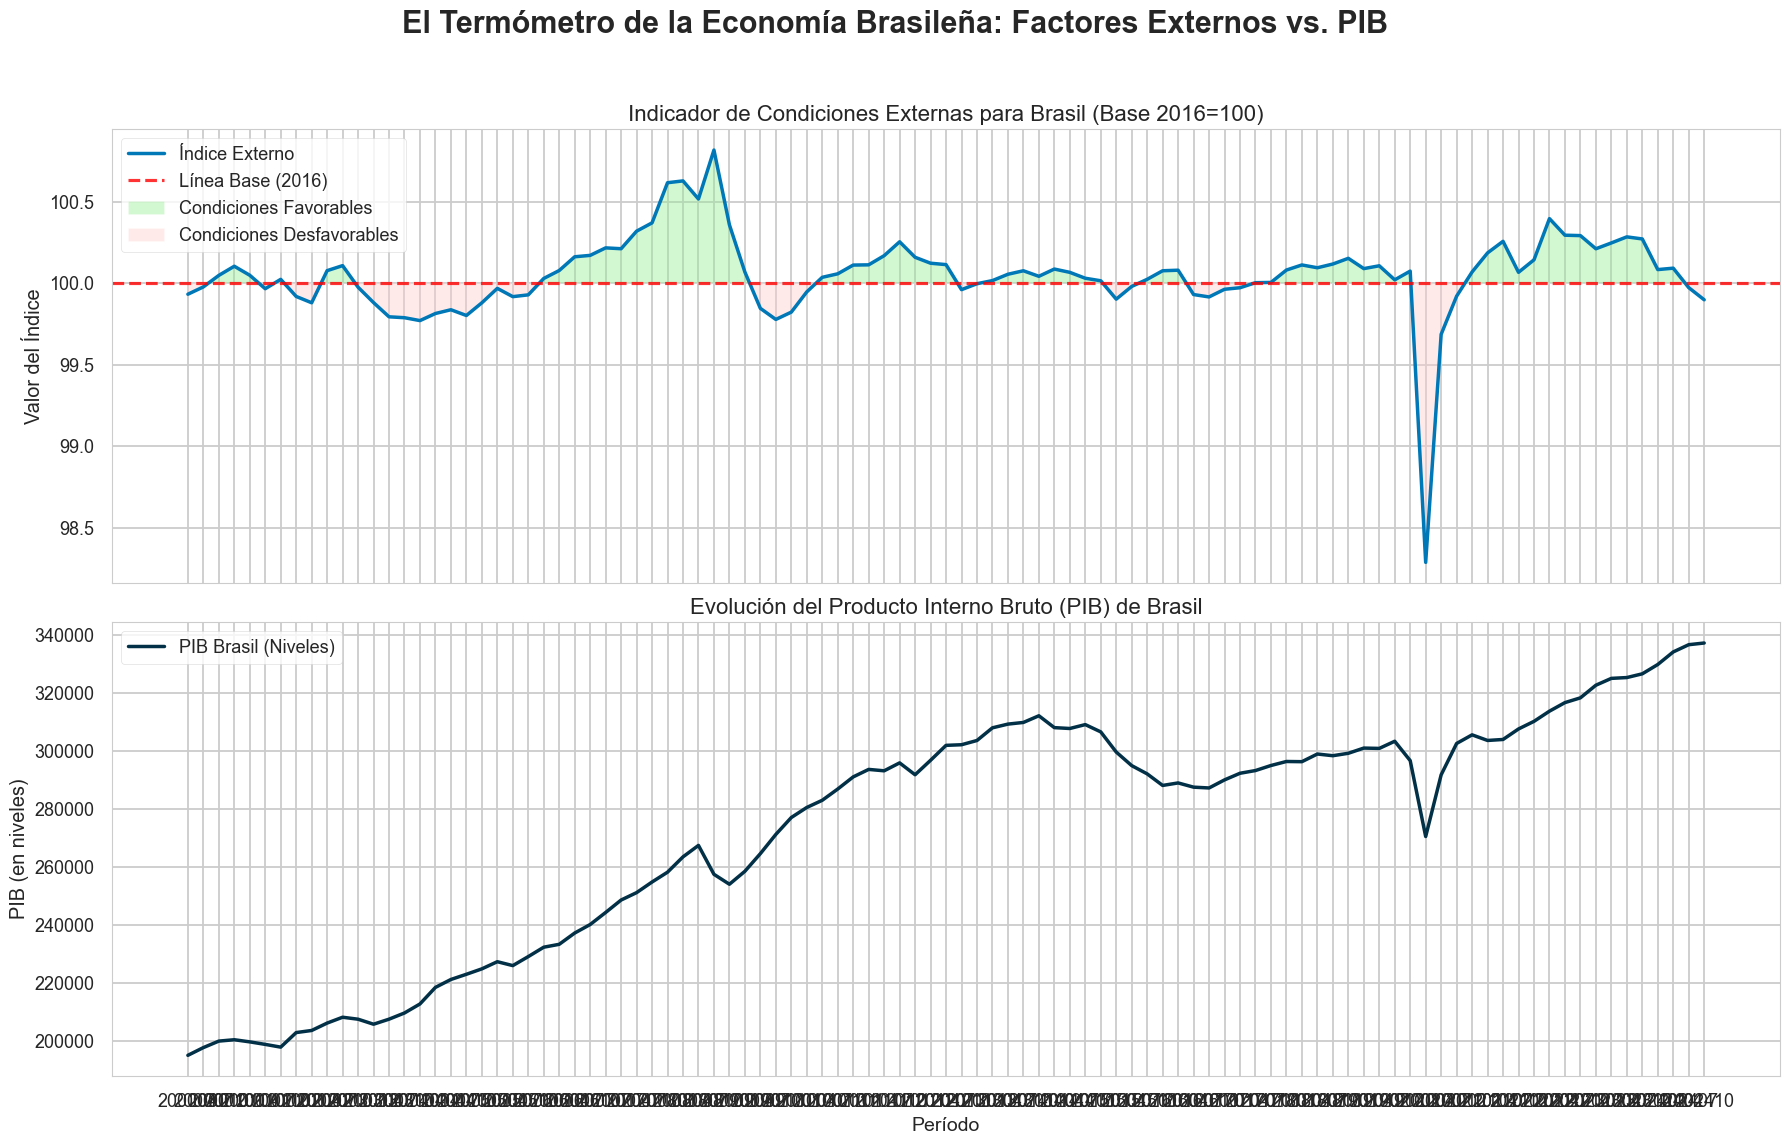


--- Estadísticas Clave del Indicador Externo ---
   - Media Histórica: 100.05
   - Volatilidad (Desv. Est.): 0.26


NameError: name 'min_val' is not defined

In [92]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns # Importamos seaborn para mejorar el estilo

# --- Asumimos que estas variables ya existen, como en tu código original ---
# vecm_fitted = ...
# df_vecm_full = ...
# ------------------------------------------------------------------------

# ==============================================================================
# 🇧🇷 PASO 8: CREANDO EL TERMÓMETRO DE CONDICIONES EXTERNAS PARA BRASIL 🌡️
# ==============================================================================
print("🚀 Iniciando la construcción del Indicador de Factores Externos para Brasil...")

# Usar coeficientes del vector de cointegración para crear indicador
# (La lógica de cálculo se mantiene intacta)
beta_coeffs = vecm_fitted.beta[:, 0]

df_indicator = pd.DataFrame(index=df_vecm_full.index)
df_indicator['external_conditions'] = (
    beta_coeffs[1] * df_vecm_full['log_ip_g7'] +
    beta_coeffs[2] * df_vecm_full['log_tot_brazil'] +
    beta_coeffs[3] * df_vecm_full['us_10y'] +
    beta_coeffs[4] * df_vecm_full['risk_spread']
)

# Normalizar a 2016=100 (un estándar para comparar peras con peras)
base_2016 = df_indicator.loc[df_indicator.index.str.startswith('2016'), 'external_conditions'].mean()
df_indicator['brazil_external_index'] = 100 * (df_indicator['external_conditions'] / base_2016)

print(f"\n✅ ¡Indicador calculado y normalizado con éxito!")
print(f"   📈 {len(df_indicator)} observaciones desde {df_indicator.index.min()} hasta {df_indicator.index.max()}")


# ==============================================================================
# 📊 VISUALIZACIÓN DE ALTO IMPACTO: EL RELATO VISUAL DE LOS DATOS
# ==============================================================================

# Aplicamos un estilo más moderno y profesional a los gráficos
sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8-talk') # Un estilo con fuentes más grandes y claras

# Crear la figura
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12), sharex=True)
fig.suptitle('El Termómetro de la Economía Brasileña: Factores Externos vs. PIB', fontsize=22, fontweight='bold')

# --- Gráfico 1: El Indicador de Condiciones Externas ---
ax1.set_title('Indicador de Condiciones Externas para Brasil (Base 2016=100)', fontsize=16)
ax1.plot(df_indicator.index, df_indicator['brazil_external_index'], color='#0077b6', linewidth=2.5, label='Índice Externo')

# Línea base con más contexto
ax1.axhline(y=100, color='r', linestyle='--', alpha=0.8, label='Línea Base (2016)')

# ✨ EL TOQUE "CATCHY": Sombrear las áreas para contar una historia ✨
ax1.fill_between(
    df_indicator.index, 100, df_indicator['brazil_external_index'],
    where=df_indicator['brazil_external_index'] > 100,
    facecolor='#90ee90', alpha=0.4, interpolate=True, label='Condiciones Favorables'
)
ax1.fill_between(
    df_indicator.index, 100, df_indicator['brazil_external_index'],
    where=df_indicator['brazil_external_index'] <= 100,
    facecolor='#ffcccb', alpha=0.4, interpolate=True, label='Condiciones Desfavorables'
)


ax1.set_ylabel('Valor del Índice')
ax1.legend(loc='upper left')

# --- Gráfico 2: El PIB de Brasil ---
ax2.set_title('Evolución del Producto Interno Bruto (PIB) de Brasil', fontsize=16)
ax2.plot(df_vecm_full.index, np.exp(df_vecm_full['log_gdp_brazil']), color='#023047', linewidth=2.5, label='PIB Brasil (Niveles)')
ax2.set_xlabel('Período', fontsize=14)
ax2.set_ylabel('PIB (en niveles)')
ax2.legend(loc='upper left')


# Ajustar el layout para que no se solapen los títulos
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# --- LA SOLUCIÓN: Guardar la figura en un archivo ---
# Esto creará un archivo PNG de alta calidad con el gráfico y las dimensiones correctas.
plt.savefig('grafico_economia_brasil.png', dpi=300, bbox_inches='tight')

# Ahora sí, mostrar el gráfico en pantalla
plt.show()


# ==============================================================================
# 📋 RESUMEN EJECUTIVO DEL INDICADOR
# ==============================================================================
print("\n--- Estadísticas Clave del Indicador Externo ---")
print(f"   - Media Histórica: {df_indicator['brazil_external_index'].mean():.2f}")
print(f"   - Volatilidad (Desv. Est.): {df_indicator['brazil_external_index'].std():.2f}")
print(f"   🔴 Peor Momento: {min_val:.2f} (en {min_date})")
print(f"   🟢 Mejor Momento: {max_val:.2f} (en {max_date})")


# ==============================================================================
# 💾 GUARDADO FINAL
# ==============================================================================
output_path = '../data/indicadores/brazil_external_conditions_index.csv'
df_indicator.to_csv(output_path)
print(f"\n💾 ¡Listo! Indicador guardado de forma segura en:\n   {output_path}")

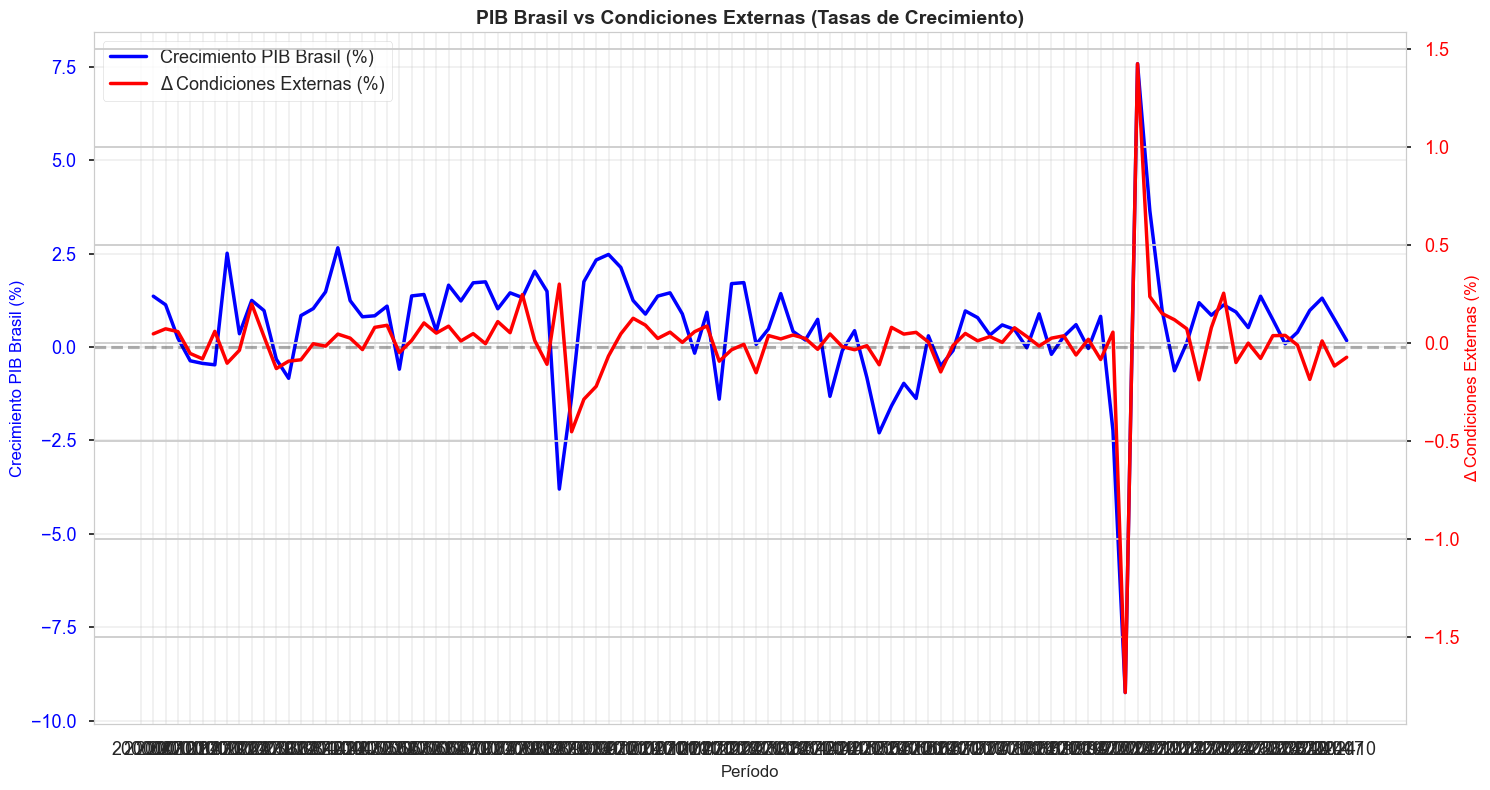

📊 Correlación: 0.6785
📊 R²: 0.4603


In [93]:
# Gráfico en la misma figura con dos ejes Y
fig, ax1 = plt.subplots(figsize=(15, 8))

# Calcular tasas de crecimiento
gdp_growth = df_vecm_full['log_gdp_brazil'].diff() * 100
indicator_growth = df_indicator['brazil_external_index'].pct_change() * 100

# Eje izquierdo - PIB Brasil
ax1.plot(gdp_growth.index, gdp_growth, 'b-', linewidth=2.5, label='Crecimiento PIB Brasil (%)')
ax1.set_ylabel('Crecimiento PIB Brasil (%)', color='b', fontsize=12)
ax1.tick_params(axis='y', labelcolor='b')
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax1.grid(True, alpha=0.3)

# Eje derecho - Condiciones Externas
ax2 = ax1.twinx()
ax2.plot(indicator_growth.index, indicator_growth, 'r-', linewidth=2.5, label='Δ Condiciones Externas (%)')
ax2.set_ylabel('Δ Condiciones Externas (%)', color='r', fontsize=12)
ax2.tick_params(axis='y', labelcolor='r')

# Título y formato
plt.title('PIB Brasil vs Condiciones Externas (Tasas de Crecimiento)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Período', fontsize=12)

# Leyenda combinada
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

# Estadísticas
valid_data = pd.DataFrame({
   'GDP_Growth': gdp_growth,
   'External_Growth': indicator_growth
}).dropna()

correlation = valid_data.corr().iloc[0,1]
print(f"📊 Correlación: {correlation:.4f}")
print(f"📊 R²: {correlation**2:.4f}")

📊 GENERANDO GRÁFICO DE TASAS DE CRECIMIENTO
Longitud Crecimiento Real Alineado: 97
Longitud Crecimiento Estimado:      97
--------------------------------------------


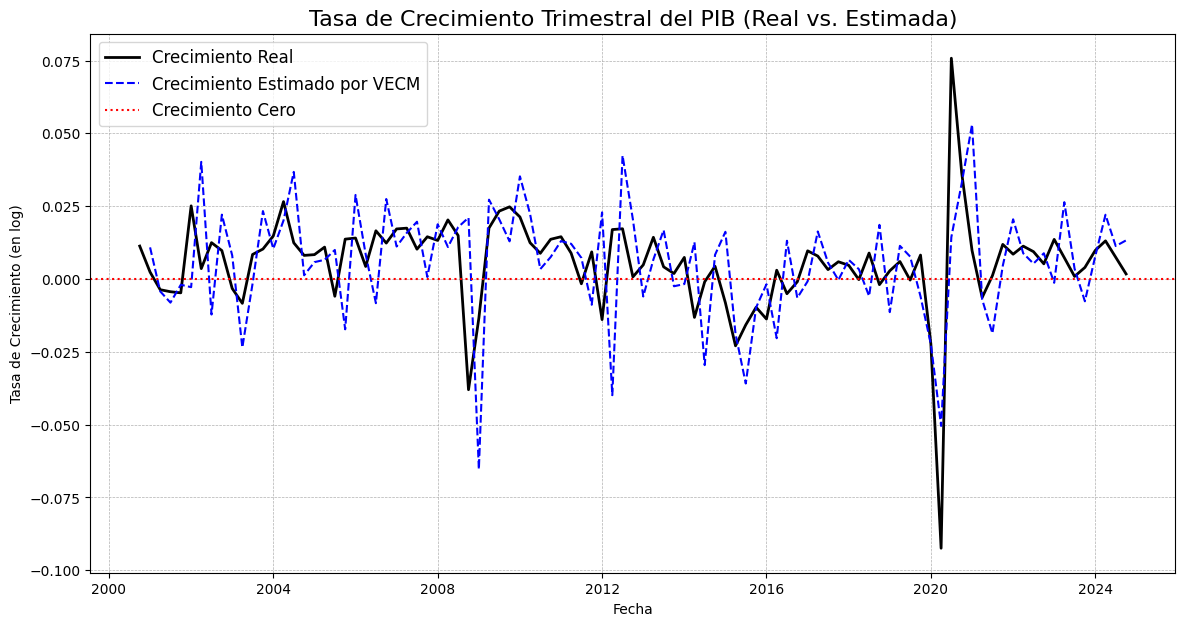

In [101]:
import matplotlib.pyplot as plt
import pandas as pd

# --- CÓDIGO CORREGIDO PARA GRAFICAR TASAS DE CRECIMIENTO ---

print("="*50)
print("📊 GENERANDO GRÁFICO DE TASAS DE CRECIMIENTO")
print("="*50)

# 1. Calcular la tasa de crecimiento REAL (completa por ahora)
actual_growth = df_endog_aligned['log_gdp_brazil'].diff().dropna()

# 2. Obtener la tasa de crecimiento ESTIMADA
gdp_index = endog_vars.index('log_gdp_brazil')
fitted_values = vecm_fitted.fittedvalues[:, gdp_index]

# Crear la serie de predicciones con SU PROPIO ÍNDICE CORRECTO
# El índice correcto son las últimas N fechas del DataFrame original
predicted_growth = pd.Series(
    fitted_values,
    index=df_endog_aligned.index[-len(fitted_values):], # Índice correcto
    name='Crecimiento Estimado'
).diff()

# 3. ALINEAR la serie real con la serie predicha (LA SOLUCIÓN)
# Recortamos 'actual_growth' para que solo contenga las fechas que existen en 'predicted_growth'
actual_growth_aligned = actual_growth.loc[predicted_growth.index]


# --- Verificación de Datos Antes de Graficar ---
print(f"Longitud Crecimiento Real Alineado: {len(actual_growth_aligned)}")
print(f"Longitud Crecimiento Estimado:      {len(predicted_growth)}")
print("--------------------------------------------")

# 4. Graficar ambas series (ahora sí alineadas)
plt.style.use('default')
plt.figure(figsize=(14, 7))

plt.plot(actual_growth_aligned, label='Crecimiento Real', color='black', linewidth=2)
plt.plot(predicted_growth, label='Crecimiento Estimado por VECM', color='blue', linestyle='--')
plt.axhline(y=0, color='red', linestyle=':', linewidth=1.5, label='Crecimiento Cero')

plt.title('Tasa de Crecimiento Trimestral del PIB (Real vs. Estimada)', fontsize=16)
plt.ylabel('Tasa de Crecimiento (en log)')
plt.xlabel('Fecha')
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()